# Notebook 07: Autoscaling Simulation

## Mục Tiêu
- Mô phỏng autoscaling với các strategies khác nhau
- So sánh Reactive vs Predictive scaling
- Phân tích chi phí và hiệu suất
- Tối ưu hóa scaling policies

---

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')

# Thêm src vào path
sys.path.insert(0, os.path.abspath('..'))

from src.data.preprocessor import load_timeseries, split_train_test
from src.autoscaling.policy import ServerConfig, ScalingPolicy, AutoscalingEngine
from src.autoscaling.simulator import AutoscalingSimulator
from src.autoscaling.cost_analyzer import CostAnalyzer
from src.models.lightgbm_forecaster import LightGBMForecaster
from src.features.feature_engineering import TimeSeriesFeatureEngineer

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data và Models

In [57]:
# Load time series
df = load_timeseries('../data/processed/timeseries_15min.parquet')
df_clean = df[df['is_storm_period'] == 0].copy()

# Use test data for simulation
train, test = split_train_test(df_clean, test_start='1995-08-23')

print(f"Simulation period: {test.index.min()} to {test.index.max()}")
print(f"Simulation length: {len(test)} intervals ({len(test)*15/60:.1f} hours)")

Simulation period: 1995-08-23 00:00:00 to 1995-08-31 23:45:00
Simulation length: 864 intervals (216.0 hours)


In [58]:
# Load trained model for predictions
try:
    model = LightGBMForecaster.load('../models/lightgbm_15min.pkl')
    print("LightGBM model loaded!")
    
    # Prepare features for predictions
    fe = TimeSeriesFeatureEngineer(df_clean)
    df_features = fe.create_all_features(target_col='request_count', granularity='15min')
    feature_cols = fe.get_feature_columns(df_features)
    X, y = fe.prepare_supervised(df_features, 'request_count', feature_cols, forecast_horizon=1)
    
    test_mask = X.index >= '1995-08-23'
    X_test = X[test_mask]
    
    # Generate predictions
    predictions = model.predict(X_test)
    predicted_demand = pd.Series(predictions, index=X_test.index)
    print(f"Predictions generated: {len(predicted_demand)}")
    
except Exception as e:
    print(f"Could not load model: {e}")
    print("Using simple moving average for predictions...")
    predicted_demand = test['request_count'].rolling(4).mean().shift(1).bfill()

LightGBM model loaded!
Creating features for 'request_count'...
  Lags: [1, 2, 4, 8, 96]
  Windows: [4, 8, 96]
  Diff periods: [1, 4, 96]
  EWM spans: [4, 96]
  + Temporal features added
  + Lag features added
  + Rolling features added
  + Diff features added
  + EWM features added

Total features: 47
NaN rows (due to lags): 528
Predictions generated: 863


## 2. Configuration

In [59]:
# Server Configuration
server_config = ServerConfig(
    max_requests_per_min=1000,      # 1000 requests/min per server
    max_bytes_per_min=50_000_000,   # 50MB/min per server
    min_servers=1,
    max_servers=50,
    cost_per_server_hour=0.10       # $0.10/hour per server
)

print("Server Configuration:")
print(f"  Max Requests/min: {server_config.max_requests_per_min:,}")
print(f"  Min Servers: {server_config.min_servers}")
print(f"  Max Servers: {server_config.max_servers}")
print(f"  Cost: ${server_config.cost_per_server_hour}/hour")

Server Configuration:
  Max Requests/min: 1,000
  Min Servers: 1
  Max Servers: 50
  Cost: $0.1/hour


In [60]:
# Scaling Policy
scaling_policy = ScalingPolicy(
    scale_out_threshold=0.8,      # Scale out at 80% utilization
    scale_in_threshold=0.3,       # Scale in at 30% utilization  
    cooldown_period=5,            # 5 intervals (75 min) cooldown
    consecutive_breaches=3,       # Need 3 consecutive breaches
    scale_out_increment=2,        # Add 2 servers
    scale_in_decrement=1,         # Remove 1 server
    prediction_horizon=4,         # Look 1 hour ahead (4 * 15min)
    predictive_buffer=0.2         # 20% safety buffer
)

print("\nScaling Policy:")
print(f"  Scale Out Threshold: {scaling_policy.scale_out_threshold*100}%")
print(f"  Scale In Threshold: {scaling_policy.scale_in_threshold*100}%")
print(f"  Cooldown: {scaling_policy.cooldown_period} intervals")
print(f"  Consecutive Breaches: {scaling_policy.consecutive_breaches}")
print(f"  Predictive Buffer: {scaling_policy.predictive_buffer*100}%")


Scaling Policy:
  Scale Out Threshold: 80.0%
  Scale In Threshold: 30.0%
  Cooldown: 5 intervals
  Consecutive Breaches: 3
  Predictive Buffer: 20.0%


## 3. Create Simulator

In [61]:
# Initialize Simulator
simulator = AutoscalingSimulator(
    server_config=server_config,
    policy=scaling_policy
)

In [62]:
# Prepare actual demand series
actual_demand = test['request_count'].copy()
print(f"Demand statistics:")
print(f"  Mean: {actual_demand.mean():.0f} requests/interval")
print(f"  Max: {actual_demand.max():.0f} requests/interval")
print(f"  Min: {actual_demand.min():.0f} requests/interval")

Demand statistics:
  Mean: 610 requests/interval
  Max: 1650 requests/interval
  Min: 73 requests/interval


## 4. Run Simulations

### 4.1 Reactive Scaling (Based on Current Load)

In [63]:
# Reactive scaling simulation
print("Running Reactive Scaling Simulation...")
reactive_df = simulator.simulate(
    actual_data=test,
    predictions=None,  # No predictions = reactive only
    use_predictive=False,
    initial_servers=5
)

reactive_metrics = simulator.calculate_metrics(reactive_df)

print(f"\nReactive Scaling Results:")
print(f"  Total Cost: ${reactive_metrics['total_cost']:.2f}")
print(f"  Avg Servers: {reactive_metrics['avg_servers']:.1f}")
print(f"  Scaling Events: {reactive_metrics['total_scaling_events']}")
print(f"  SLA Violations: {reactive_metrics['overloaded_periods']}")
print(f"  Dropped Requests: {reactive_metrics['total_dropped_requests']:,.0f}")

Running Reactive Scaling Simulation...

Reactive Scaling Results:
  Total Cost: $2.23
  Avg Servers: 1.6
  Scaling Events: 24
  SLA Violations: 6
  Dropped Requests: 532


### 4.2 Predictive Scaling (Based on Forecasts)

In [64]:
# Predictive scaling simulation
print("Running Predictive Scaling Simulation...")

# Align predictions with actual demand - create predictions DataFrame
pred_aligned = predicted_demand.reindex(test.index).ffill()

# Build predictions DataFrame with request_count column
pred_df = test.copy()
pred_df['request_count'] = pred_aligned.values

predictive_df = simulator.simulate(
    actual_data=test,
    predictions=pred_df,
    use_predictive=True,
    initial_servers=5
)

predictive_metrics = simulator.calculate_metrics(predictive_df)

print(f"\nPredictive Scaling Results:")
print(f"  Total Cost: ${predictive_metrics['total_cost']:.2f}")
print(f"  Avg Servers: {predictive_metrics['avg_servers']:.1f}")
print(f"  Scaling Events: {predictive_metrics['total_scaling_events']}")
print(f"  SLA Violations: {predictive_metrics['overloaded_periods']}")
print(f"  Dropped Requests: {predictive_metrics['total_dropped_requests']:,.0f}")

Running Predictive Scaling Simulation...

Predictive Scaling Results:
  Total Cost: $2.12
  Avg Servers: 1.5
  Scaling Events: 27
  SLA Violations: 0
  Dropped Requests: 0


## 5. Strategy Comparison

In [65]:
# Compare all strategies using simulator's built-in comparison
comparison_df = simulator.compare_strategies(
    actual_data=test,
    predictions=pred_df
)

print("\nStrategy Comparison:")
print(comparison_df.to_string(index=False))

Simulating: Reactive Only...
Simulating: Predictive...
Simulating: Aggressive Scale-out...
Simulating: Conservative...

Strategy Comparison:
            strategy  total_hours  total_server_hours  total_cost  avg_servers  max_servers  min_servers  scale_out_count  scale_in_count  total_scaling_events  overloaded_periods  overload_rate_pct  total_dropped_requests  drop_rate_pct  avg_utilization  max_utilization
          Predictive        216.0           21.083333    2.108333     1.464120            3            1                8              15                    23                   0           0.000000                     0.0       0.000000         0.408528            0.899
Aggressive Scale-out        216.0           21.833333    2.183333     1.516204            4            1               20              39                    59                   0           0.000000                     0.0       0.000000         0.396604            0.993
       Reactive Only        216.0          

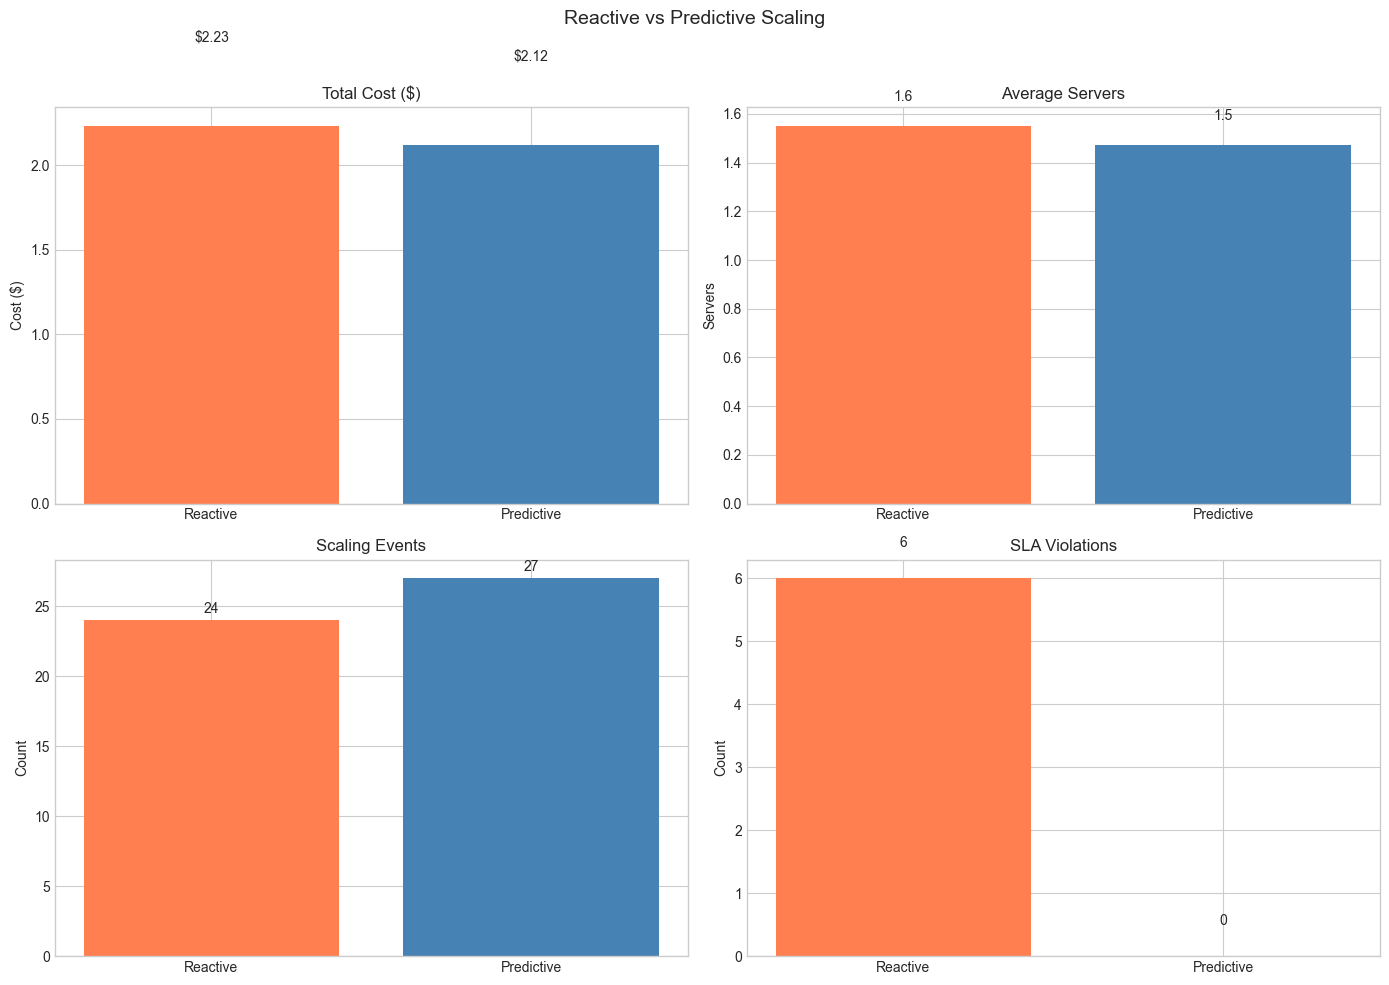

In [66]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cost comparison
costs = [reactive_metrics['total_cost'], predictive_metrics['total_cost']]
axes[0, 0].bar(['Reactive', 'Predictive'], costs, color=['coral', 'steelblue'])
axes[0, 0].set_title('Total Cost ($)')
axes[0, 0].set_ylabel('Cost ($)')
for i, v in enumerate(costs):
    axes[0, 0].text(i, v + 0.5, f'${v:.2f}', ha='center')

# Average servers
avg_servers = [reactive_metrics['avg_servers'], predictive_metrics['avg_servers']]
axes[0, 1].bar(['Reactive', 'Predictive'], avg_servers, color=['coral', 'steelblue'])
axes[0, 1].set_title('Average Servers')
axes[0, 1].set_ylabel('Servers')
for i, v in enumerate(avg_servers):
    axes[0, 1].text(i, v + 0.1, f'{v:.1f}', ha='center')

# Scaling events
events = [reactive_metrics['total_scaling_events'], predictive_metrics['total_scaling_events']]
axes[1, 0].bar(['Reactive', 'Predictive'], events, color=['coral', 'steelblue'])
axes[1, 0].set_title('Scaling Events')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate(events):
    axes[1, 0].text(i, v + 0.5, str(v), ha='center')

# SLA violations
violations = [reactive_metrics['overloaded_periods'], predictive_metrics['overloaded_periods']]
axes[1, 1].bar(['Reactive', 'Predictive'], violations, color=['coral', 'steelblue'])
axes[1, 1].set_title('SLA Violations')
axes[1, 1].set_ylabel('Count')
for i, v in enumerate(violations):
    axes[1, 1].text(i, v + 0.5, str(v), ha='center')

plt.suptitle('Reactive vs Predictive Scaling', fontsize=14)
plt.tight_layout()
plt.savefig('../reports/figures/autoscaling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Timeline Visualization

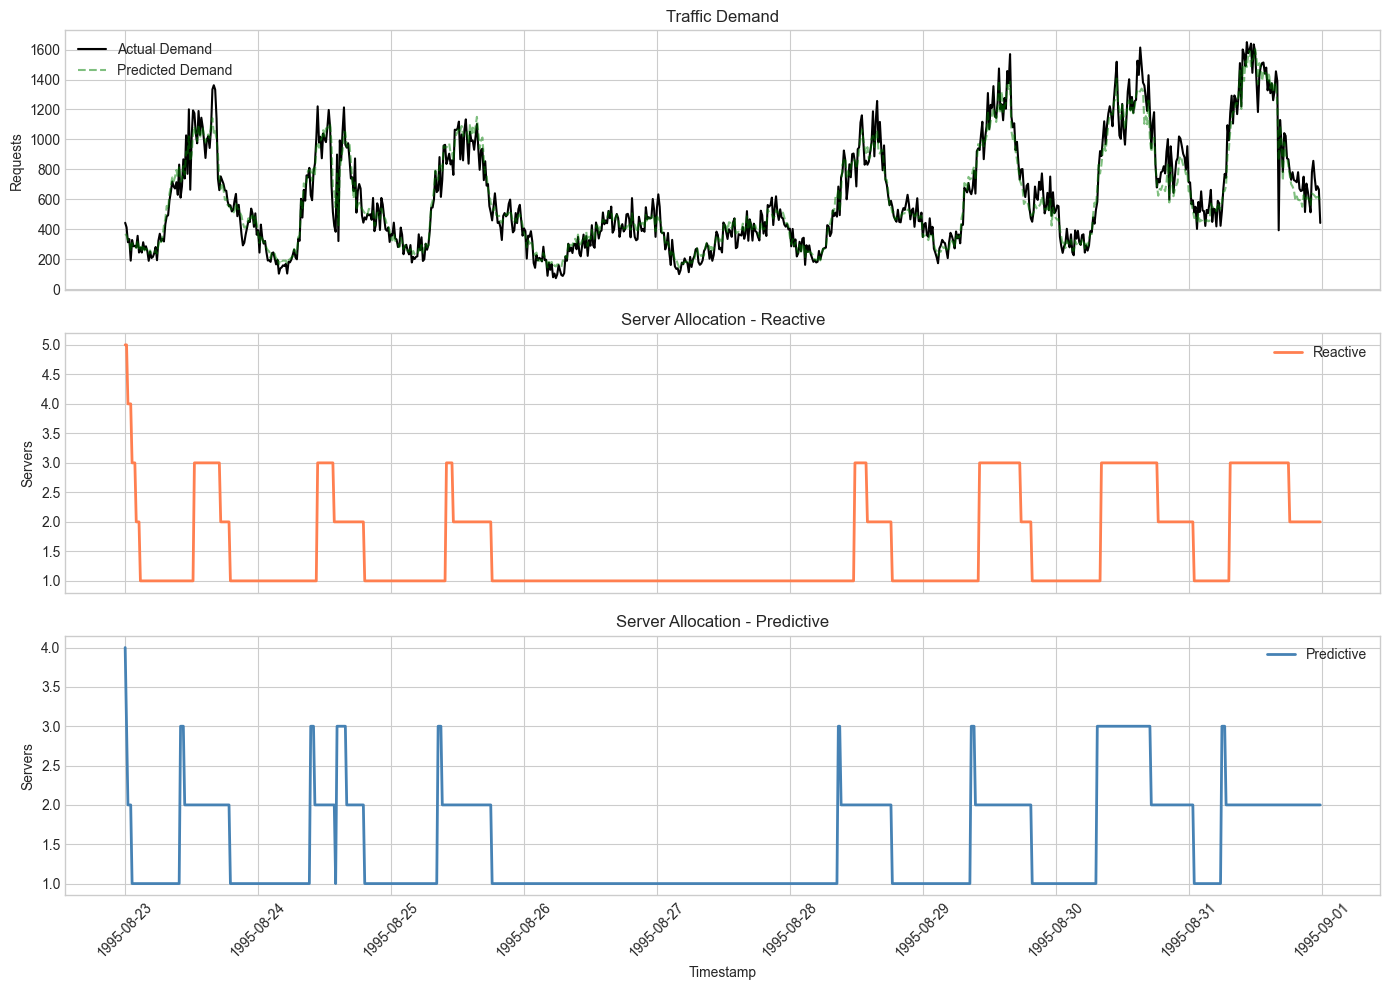

In [67]:
# Plot server allocation over time
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

actual_demand = test['request_count']

# Demand
axes[0].plot(actual_demand.index, actual_demand.values, color='black', label='Actual Demand')
pred_aligned_plot = predicted_demand.reindex(actual_demand.index).ffill()
axes[0].plot(pred_aligned_plot.index, pred_aligned_plot.values, color='green', alpha=0.5, 
             linestyle='--', label='Predicted Demand')
axes[0].set_ylabel('Requests')
axes[0].set_title('Traffic Demand')
axes[0].legend()

# Reactive servers
axes[1].plot(reactive_df.index, reactive_df['servers'].values, 
             color='coral', label='Reactive', linewidth=2)
axes[1].set_ylabel('Servers')
axes[1].set_title('Server Allocation - Reactive')
axes[1].legend()

# Predictive servers
axes[2].plot(predictive_df.index, predictive_df['servers'].values, 
             color='steelblue', label='Predictive', linewidth=2)
axes[2].set_ylabel('Servers')
axes[2].set_title('Server Allocation - Predictive')
axes[2].set_xlabel('Timestamp')
axes[2].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/autoscaling_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

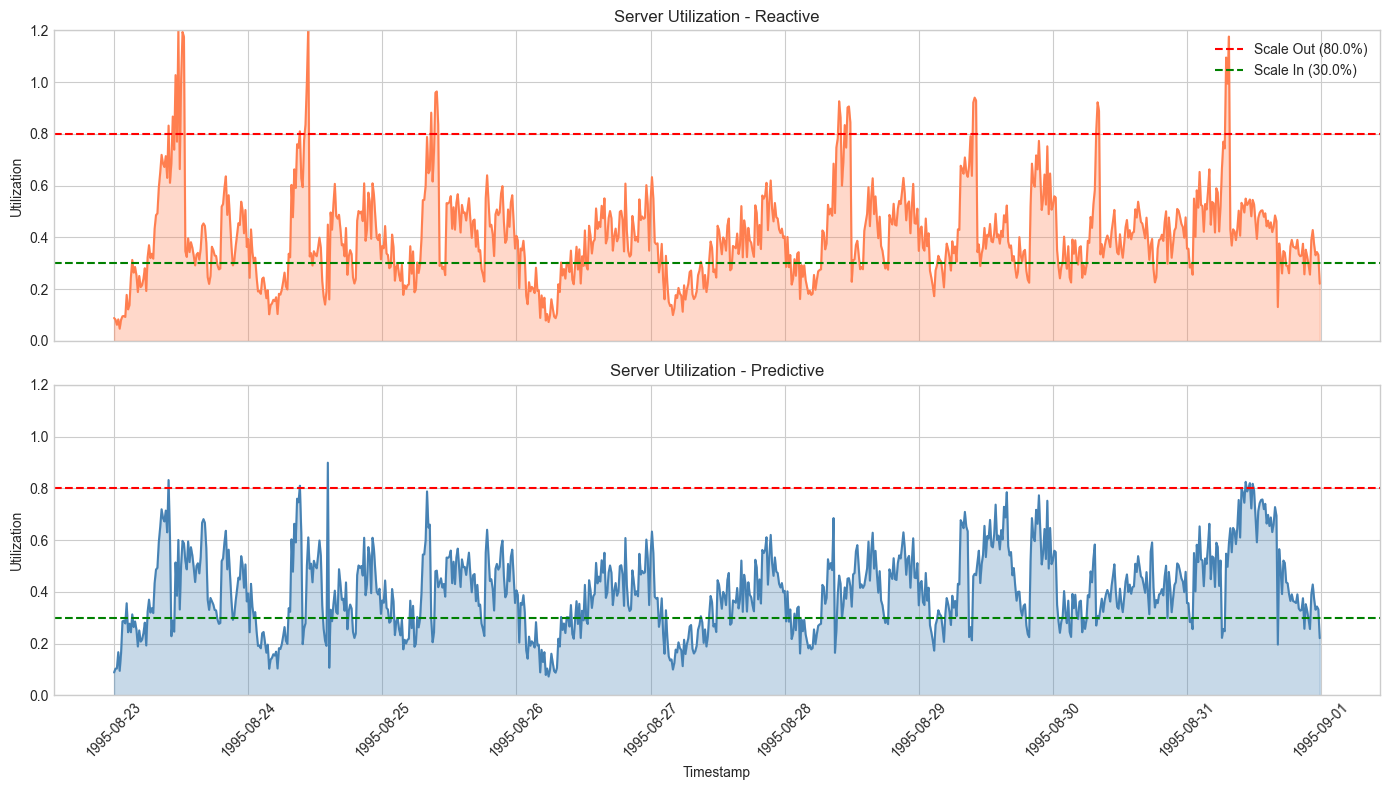

In [68]:
# Utilization comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

reactive_util = reactive_df['utilization']
predictive_util = predictive_df['utilization']

axes[0].plot(reactive_df.index, reactive_util.values, color='coral')
axes[0].axhline(y=scaling_policy.scale_out_threshold, color='red', linestyle='--', 
                label=f'Scale Out ({scaling_policy.scale_out_threshold*100}%)')
axes[0].axhline(y=scaling_policy.scale_in_threshold, color='green', linestyle='--',
                label=f'Scale In ({scaling_policy.scale_in_threshold*100}%)')
axes[0].fill_between(reactive_df.index, 0, reactive_util.values, alpha=0.3, color='coral')
axes[0].set_ylabel('Utilization')
axes[0].set_title('Server Utilization - Reactive')
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, 1.2)

axes[1].plot(predictive_df.index, predictive_util.values, color='steelblue')
axes[1].axhline(y=scaling_policy.scale_out_threshold, color='red', linestyle='--')
axes[1].axhline(y=scaling_policy.scale_in_threshold, color='green', linestyle='--')
axes[1].fill_between(predictive_df.index, 0, predictive_util.values, alpha=0.3, color='steelblue')
axes[1].set_ylabel('Utilization')
axes[1].set_title('Server Utilization - Predictive')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylim(0, 1.2)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/autoscaling_utilization.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Cost Analysis

In [69]:
# Cost analyzer
cost_analyzer = CostAnalyzer(server_config)

# Generate cost report using reactive simulation results
reactive_servers_series = reactive_df['servers']
actual_demand = test['request_count']

report = cost_analyzer.generate_cost_report(
    demand_series=actual_demand[:len(reactive_servers_series)],
    server_series=reactive_servers_series,
    freq_minutes=15
)

print(report)


                    COST ANALYSIS REPORT

CONFIGURATION:
  Server Capacity: 1,000 requests/min
  Cost per Server-Hour: $0.10
  Analysis Period: 864 intervals (216.0 hours)

DEMAND STATISTICS:
  Total Requests: 526,646
  Average Demand: 609.5 / interval
  Peak Demand: 1,650 / interval
  P90 Demand: 1,154 / interval

STRATEGY COMPARISON:
       Strategy  Total Cost ($)  Avg Servers  Peak Servers  Min Servers  Overprov Cost ($)  Underprov Events  Dropped Requests  SLA Violation (%)  Server Hours  Savings ($)  Savings (%)
   Fixed (Peak)            21.6     1.000000             1            1          20.722257                 0                 0                0.0         216.0          0.0         0.00
    Fixed (P90)            21.6     1.000000             1            1          20.722257                 0                 0                0.0         216.0          0.0         0.00
Fixed (Average)            21.6     1.000000             1            1          20.722257             

In [70]:
# Cost comparison with fixed provisioning
demand_aligned = actual_demand[:len(predictive_df)]

# Calculate costs for different strategies
fixed_peak, fixed_peak_metrics = cost_analyzer.calculate_optimal_fixed_servers(
    demand_aligned, sla_target=99.0, freq_minutes=15
)

print(f"\nOptimal Fixed Servers for 99% SLA: {fixed_peak}")
print(f"Fixed Cost: ${fixed_peak_metrics.total_cost:.2f}")
print(f"\nComparison:")
print(f"  Fixed Provisioning: ${fixed_peak_metrics.total_cost:.2f}")
print(f"  Reactive Scaling: ${reactive_metrics['total_cost']:.2f}")
print(f"  Predictive Scaling: ${predictive_metrics['total_cost']:.2f}")

savings_reactive = fixed_peak_metrics.total_cost - reactive_metrics['total_cost']
savings_predictive = fixed_peak_metrics.total_cost - predictive_metrics['total_cost']

print(f"\nSavings vs Fixed:")
print(f"  Reactive: ${savings_reactive:.2f} ({savings_reactive/fixed_peak_metrics.total_cost*100:.1f}%)")
print(f"  Predictive: ${savings_predictive:.2f} ({savings_predictive/fixed_peak_metrics.total_cost*100:.1f}%)")


Optimal Fixed Servers for 99% SLA: 1
Fixed Cost: $21.60

Comparison:
  Fixed Provisioning: $21.60
  Reactive Scaling: $2.23
  Predictive Scaling: $2.12

Savings vs Fixed:
  Reactive: $19.37 (89.7%)
  Predictive: $19.48 (90.2%)


## 8. Sensitivity Analysis

In [71]:
# Test different buffer sizes
print("Running sensitivity analysis on predictive buffer...")

buffer_results = simulator.run_sensitivity_analysis(
    actual_data=test,
    predictions=pred_df,  # Use DataFrame not Series
    param_name='predictive_buffer',
    param_values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
)

# Show results with correct column names
print(buffer_results[['predictive_buffer', 'total_cost', 'avg_servers', 
                      'overloaded_periods', 'total_dropped_requests']].to_string(index=False))

Running sensitivity analysis on predictive buffer...
Testing predictive_buffer=0.0...
Testing predictive_buffer=0.1...
Testing predictive_buffer=0.2...
Testing predictive_buffer=0.3...
Testing predictive_buffer=0.4...
Testing predictive_buffer=0.5...
 predictive_buffer  total_cost  avg_servers  overloaded_periods  total_dropped_requests
               0.0    2.115000     1.468750                   0                       0
               0.1    2.185000     1.517361                   0                       0
               0.2    2.108333     1.464120                   0                       0
               0.3    2.130000     1.479167                   0                       0
               0.4    2.170000     1.506944                   0                       0
               0.5    2.270000     1.576389                   0                       0


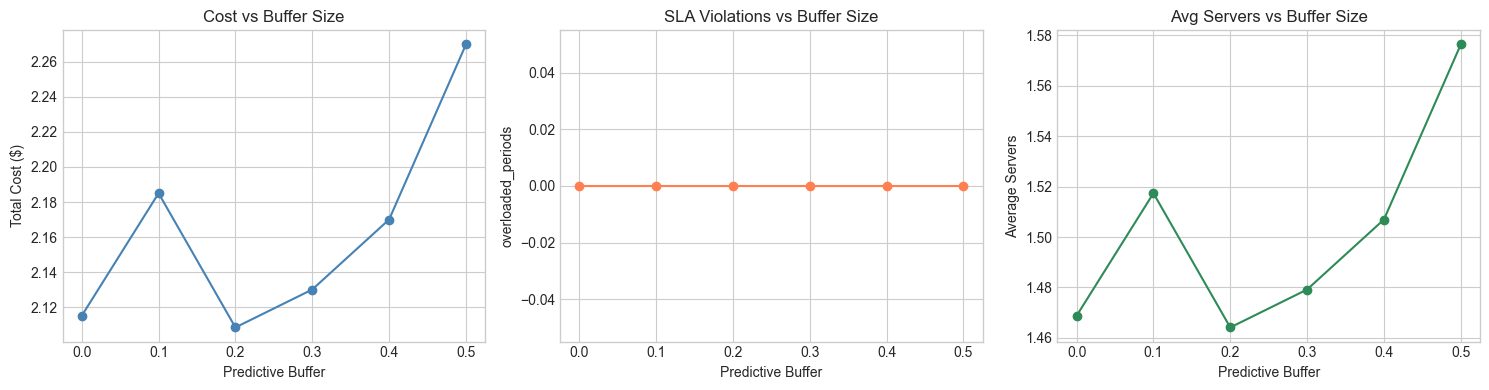

In [72]:
# Visualize sensitivity analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

buffer_values = buffer_results['predictive_buffer'].values

# Cost vs Buffer
axes[0].plot(buffer_values, buffer_results['total_cost'], marker='o', color='steelblue')
axes[0].set_xlabel('Predictive Buffer')
axes[0].set_ylabel('Total Cost ($)')
axes[0].set_title('Cost vs Buffer Size')

# SLA Violations vs Buffer
axes[1].plot(buffer_values, buffer_results['overloaded_periods'], marker='o', color='coral')
axes[1].set_xlabel('Predictive Buffer')
axes[1].set_ylabel('overloaded_periods')
axes[1].set_title('SLA Violations vs Buffer Size')

# Avg Servers vs Buffer
axes[2].plot(buffer_values, buffer_results['avg_servers'], marker='o', color='seagreen')
axes[2].set_xlabel('Predictive Buffer')
axes[2].set_ylabel('Average Servers')
axes[2].set_title('Avg Servers vs Buffer Size')

plt.tight_layout()
plt.savefig('../reports/figures/autoscaling_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Summary

In [73]:
print("="*70)
print("              AUTOSCALING SIMULATION SUMMARY")
print("="*70)
print(f"\nSimulation Period: {test.index.min()} to {test.index.max()}")
print(f"Duration: {len(test)*15/60:.1f} hours ({len(test)} intervals)")
print(f"\nServer Configuration:")
print(f"  Capacity: {server_config.max_requests_per_min} requests/min")
print(f"  Cost: ${server_config.cost_per_server_hour}/hour")
print(f"\n" + "-"*70)
print("STRATEGY COMPARISON:")
print("-"*70)
print(f"{'Strategy':<15} {'Cost ($)':<12} {'Avg Servers':<12} {'SLA Violations':<15} {'Dropped Req':<12}")
print("-"*70)
print(f"{'Fixed Peak':<15} {fixed_peak_metrics.total_cost:<12.2f} {fixed_peak:<12} {fixed_peak_metrics.underprovisioning_events:<15} {fixed_peak_metrics.dropped_requests:<12,}")
print(f"{'Reactive':<15} {reactive_metrics['total_cost']:<12.2f} {reactive_metrics['avg_servers']:<12.1f} {reactive_metrics['overloaded_periods']:<15} {reactive_metrics['total_dropped_requests']:<12,.0f}")
print(f"{'Predictive':<15} {predictive_metrics['total_cost']:<12.2f} {predictive_metrics['avg_servers']:<12.1f} {predictive_metrics['overloaded_periods']:<15} {predictive_metrics['total_dropped_requests']:<12,.0f}")
print("-"*70)
print(f"\nKEY FINDINGS:")
print(f"  - Predictive scaling saves ${savings_predictive:.2f} vs fixed provisioning")
print(f"  - Cost reduction: {savings_predictive/fixed_peak_metrics.total_cost*100:.1f}%")
print("="*70)

              AUTOSCALING SIMULATION SUMMARY

Simulation Period: 1995-08-23 00:00:00 to 1995-08-31 23:45:00
Duration: 216.0 hours (864 intervals)

Server Configuration:
  Capacity: 1000 requests/min
  Cost: $0.1/hour

----------------------------------------------------------------------
STRATEGY COMPARISON:
----------------------------------------------------------------------
Strategy        Cost ($)     Avg Servers  SLA Violations  Dropped Req 
----------------------------------------------------------------------
Fixed Peak      21.60        1            0               0           
Reactive        2.23         1.6          6               532         
Predictive      2.12         1.5          0               0           
----------------------------------------------------------------------

KEY FINDINGS:
  - Predictive scaling saves $19.48 vs fixed provisioning
  - Cost reduction: 90.2%
